
# Perceptual Stimuli Generator (Calibrated) — API-Ready

This notebook reproduces the **perceptual task** from Juni & Eckstein (2015):
- Gaussian luminance blob (σ = 0.5°) embedded in additive **luminance white noise**.
- **Mean luminance ≈ 28 cd/m²**, **noise SD = 4.375 cd/m²** (RMS contrast ≈ 0.1562).
- Display mapping is **fixed linear** so 28 cd/m² → **8‑bit 128** (no contrast stretching).
- Conditions: **equal** (2% peak contrast), **weak** (0.5%), **strong** (9%).

**Outputs**
1) Calibrated PNGs per condition/label (present|absent), plus optional .npy floats.  
2) Flat `allimgs/` with `index.csv` for APIs.  
3) API-friendly `trials.csv` (`TrialID,Condition,Truth,Image`).  
4) **Separate noise bank** (`noise_bank/`) with `.npy` and a `noise_index.csv`
   for downstream statistics after model runs.


## 1) Imports & constants

In [3]:

from pathlib import Path
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image
import csv, json, math, random, shutil
import pandas as pd

# ===== Experiment constants (per paper) =====
MEAN_LUMINANCE = 28.0             # cd/m^2
NOISE_SD = 4.375                  # cd/m^2
FIELD_DEG = 15.0                  # degrees
PIXELS_PER_DEG = 1.0/0.037        # ≈ 27.027 px/deg
IMG_SIZE = int(round(FIELD_DEG * PIXELS_PER_DEG))  # ≈ 405 px
SIGMA_DEG = 0.5
SIGMA_PX  = SIGMA_DEG * PIXELS_PER_DEG            # ≈ 13.5 px

# Peak contrasts — map to amplitudes = contrast * MEAN_LUMINANCE
PEAK_CONTRAST_EQUAL  = 0.02
PEAK_CONTRAST_WEAK   = 0.005
PEAK_CONTRAST_STRONG = 0.09

TARGET_SNRS = {"equal": 3.07, "weak": 0.77, "strong": 13.8}

# ===== Display calibration (fixed linear counts ← cd/m^2) =====
DISPLAY_MEAN_8BIT = 128.0
DISPLAY_GAIN      = DISPLAY_MEAN_8BIT / MEAN_LUMINANCE  # ~ 4.57 counts per cd/m^2

# RNG (set to seed for reproducibility)
RANDOM_SEED = None
if RANDOM_SEED is not None:
    np.random.seed(RANDOM_SEED)

# Dataset/export knobs
OUTPUT_DIR = Path("perceptual_dataset_calibrated")
TRIALS_PER_CONDITION = 200
SAVE_NPY = True
SAVE_SIGNAL_PNG = True

# Noise bank export
NOISE_BANK_DIR = Path("noise_bank")
NOISE_BANK_DIR.mkdir(parents=True, exist_ok=True)

IMG_SIZE, SIGMA_PX, DISPLAY_GAIN


(405, 13.513513513513514, 4.571428571428571)

## 2) Stimulus functions (float cd/m² domain)

In [4]:

def gaussian_blob(size, sigma_px, amplitude, center=None):
    h = w = size
    cy, cx = ((h-1)/2.0, (w-1)/2.0) if center is None else center
    y = np.arange(h)[:, None]; x = np.arange(w)[None, :]
    g = np.exp(-(((y - cy)**2 + (x - cx)**2)/(2*sigma_px**2)))
    return amplitude * g

def white_noise(size, mean_lum=MEAN_LUMINANCE, sigma=NOISE_SD):
    return np.random.normal(mean_lum, sigma, (size, size))

def make_stimulus(present=True, peak_contrast=PEAK_CONTRAST_EQUAL):
    noise = white_noise(IMG_SIZE)
    if present:
        amp = peak_contrast * MEAN_LUMINANCE
        signal = gaussian_blob(IMG_SIZE, SIGMA_PX, amp)
        combined = noise + signal
    else:
        signal = np.zeros((IMG_SIZE, IMG_SIZE), dtype=float)
        combined = noise
    return combined, noise, signal

def to_uint8_visible(lum_float):
    counts = lum_float * DISPLAY_GAIN
    return np.clip(counts, 0, 255).astype(np.uint8)

def to_uint8_visible_signal(signal_float):
    return to_uint8_visible(MEAN_LUMINANCE + signal_float)


## 3) Demo — Absent vs Present (equal condition)

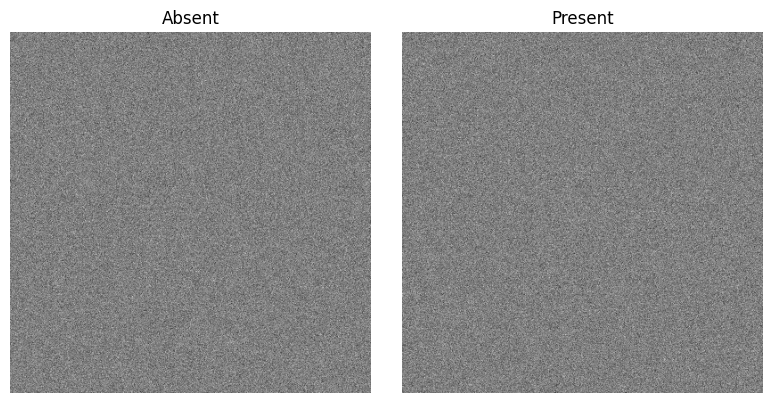

DISPLAY_GAIN = 4.5714 (28 cd/m² → 128.0 counts)


In [5]:

fig, axes = plt.subplots(1, 2, figsize=(8,4))
img_abs, noise_abs, sig_abs = make_stimulus(present=False, peak_contrast=PEAK_CONTRAST_EQUAL)
img_pre, noise_pre, sig_pre = make_stimulus(present=True,  peak_contrast=PEAK_CONTRAST_EQUAL)

axes[0].imshow(to_uint8_visible(img_abs), cmap='gray', vmin=0, vmax=255); axes[0].set_title('Absent'); axes[0].axis('off')
axes[1].imshow(to_uint8_visible(img_pre), cmap='gray', vmin=0, vmax=255); axes[1].set_title('Present'); axes[1].axis('off')
plt.tight_layout(); plt.show()

print(f"DISPLAY_GAIN = {DISPLAY_GAIN:.4f} (28 cd/m² → {DISPLAY_MEAN_8BIT} counts)")


## 4) Export helpers

In [6]:

def ensure_dirs(base: Path, cond: str):
    for label in ("absent", "present"):
        (base / cond / label / "combined").mkdir(parents=True, exist_ok=True)
        (base / cond / label / "noise").mkdir(parents=True, exist_ok=True)
        (base / cond / label / "signal").mkdir(parents=True, exist_ok=True)

def save_trial(out_dir: Path, cond: str, label: str, idx: int, combined, noise, signal):
    stem = f"{cond}_{label}_{idx:03d}"
    # Calibrated PNGs
    Image.fromarray(to_uint8_visible(combined)).save(out_dir/cond/label/"combined"/f"{stem}_combined.png")
    Image.fromarray(to_uint8_visible(noise)).save(out_dir/cond/label/"noise"/f"{stem}_noise.png")
    if SAVE_SIGNAL_PNG:
        Image.fromarray(to_uint8_visible_signal(signal)).save(out_dir/cond/label/"signal"/f"{stem}_signal.png")
    # Optional NPYS
    if SAVE_NPY:
        np.save(out_dir/cond/label/"combined"/f"{stem}_combined.npy", combined)
        np.save(out_dir/cond/label/"noise"/f"{stem}_noise.npy", noise)
        np.save(out_dir/cond/label/"signal"/f"{stem}_signal.npy", signal)

    # --- Also write noise into a separate central NOISE BANK ---
    # Use a unique name that encodes condition/label/id for cross-ref later
    nb_name = f"nb_{cond}_{label}_{idx:03d}.npy"
    np.save(NOISE_BANK_DIR/nb_name, noise)
    return (NOISE_BANK_DIR/nb_name).as_posix()


## 5) Export dataset (calibrated PNGs + metadata + noise bank)

In [7]:

def export_dataset():
    OUTPUT_DIR.mkdir(parents=True, exist_ok=True)
    conditions = {
        "equal":  {"contrast": PEAK_CONTRAST_EQUAL,  "target_snr": TARGET_SNRS["equal"]},
        "weak":   {"contrast": PEAK_CONTRAST_WEAK,   "target_snr": TARGET_SNRS["weak"]},
        "strong": {"contrast": PEAK_CONTRAST_STRONG, "target_snr": TARGET_SNRS["strong"]},
    }

    # Global manifest
    (OUTPUT_DIR/"manifest.json").write_text(json.dumps({
        "MEAN_LUMINANCE": MEAN_LUMINANCE, "NOISE_SD": NOISE_SD, "FIELD_DEG": FIELD_DEG,
        "PIXELS_PER_DEG": PIXELS_PER_DEG, "IMG_SIZE": IMG_SIZE, "SIGMA_DEG": SIGMA_DEG,
        "SIGMA_PX": SIGMA_PX, "DISPLAY_GAIN": DISPLAY_GAIN,
        "PEAK_CONTRAST_EQUAL": PEAK_CONTRAST_EQUAL,
        "PEAK_CONTRAST_WEAK": PEAK_CONTRAST_WEAK,
        "PEAK_CONTRAST_STRONG": PEAK_CONTRAST_STRONG,
        "TARGET_SNRS": TARGET_SNRS, "TRIALS_PER_CONDITION": TRIALS_PER_CONDITION
    }, indent=2))

    # Per-trial metadata & a separate noise index for banked noise
    meta_rows = []
    noise_rows = []

    for cond, info in conditions.items():
        ensure_dirs(OUTPUT_DIR, cond)
        contrast = info["contrast"]; target_snr = info["target_snr"]

        # Template norm (unit-peak blob) for SNR sanity
        tpl = gaussian_blob(IMG_SIZE, SIGMA_PX, amplitude=1.0)
        K = math.sqrt(np.sum(tpl**2))
        emp_snr_template = (contrast * MEAN_LUMINANCE * K) / NOISE_SD

        for i in range(1, TRIALS_PER_CONDITION+1):
            # Absent
            comb, noi, sig = make_stimulus(present=False, peak_contrast=contrast)
            nb_path = save_trial(OUTPUT_DIR, cond, "absent", i, comb, noi, sig)
            mean_n, sd_n = float(np.mean(noi)), float(np.std(noi, ddof=1))
            rms = sd_n / max(mean_n, 1e-9)
            stem = f"{cond}_absent_{i:03d}"
            meta_rows.append({
                "trial_id": i, "condition": cond, "label": "absent",
                "contrast": contrast, "target_snr": target_snr,
                "mean_noise": mean_n, "sd_noise": sd_n, "rms_contrast": rms,
                "empirical_snr_template": emp_snr_template,
                "combined_png": str(OUTPUT_DIR/cond/"absent"/"combined"/f"{stem}_combined.png"),
                "noise_png":    str(OUTPUT_DIR/cond/"absent"/"noise"/f"{stem}_noise.png"),
                "signal_png":   str(OUTPUT_DIR/cond/"absent"/"signal"/f"{stem}_signal.png") if SAVE_SIGNAL_PNG else "",
                "combined_npy": str(OUTPUT_DIR/cond/"absent"/"combined"/f"{stem}_combined.npy") if SAVE_NPY else "",
                "noise_npy":    str(OUTPUT_DIR/cond/"absent"/"noise"/f"{stem}_noise.npy") if SAVE_NPY else "",
                "signal_npy":   str(OUTPUT_DIR/cond/"absent"/"signal"/f"{stem}_signal.npy") if SAVE_NPY else "",
                "noise_bank_npy": nb_path
            })
            noise_rows.append({
                "noise_bank_npy": nb_path, "condition": cond, "label": "absent",
                "trial_id": i, "mean_noise": mean_n, "sd_noise": sd_n, "rms_contrast": rms
            })

            # Present
            comb, noi, sig = make_stimulus(present=True, peak_contrast=contrast)
            nb_path = save_trial(OUTPUT_DIR, cond, "present", i, comb, noi, sig)
            mean_n, sd_n = float(np.mean(noi)), float(np.std(noi, ddof=1))
            rms = sd_n / max(mean_n, 1e-9)
            stem = f"{cond}_present_{i:03d}"
            meta_rows.append({
                "trial_id": i, "condition": cond, "label": "present",
                "contrast": contrast, "target_snr": target_snr,
                "mean_noise": mean_n, "sd_noise": sd_n, "rms_contrast": rms,
                "empirical_snr_template": emp_snr_template,
                "combined_png": str(OUTPUT_DIR/cond/"present"/"combined"/f"{stem}_combined.png"),
                "noise_png":    str(OUTPUT_DIR/cond/"present"/"noise"/f"{stem}_noise.png"),
                "signal_png":   str(OUTPUT_DIR/cond/"present"/"signal"/f"{stem}_signal.png") if SAVE_SIGNAL_PNG else "",
                "combined_npy": str(OUTPUT_DIR/cond/"present"/"combined"/f"{stem}_combined.npy") if SAVE_NPY else "",
                "noise_npy":    str(OUTPUT_DIR/cond/"present"/"noise"/f"{stem}_noise.npy") if SAVE_NPY else "",
                "signal_npy":   str(OUTPUT_DIR/cond/"present"/"signal"/f"{stem}_signal.npy") if SAVE_NPY else "",
                "noise_bank_npy": nb_path
            })
            noise_rows.append({
                "noise_bank_npy": nb_path, "condition": cond, "label": "present",
                "trial_id": i, "mean_noise": mean_n, "sd_noise": sd_n, "rms_contrast": rms
            })

    # Write per-trial metadata
    meta_df = pd.DataFrame(meta_rows)
    meta_df.to_csv(OUTPUT_DIR/"metadata.csv", index=False)

    # Write noise bank index (centralized noise mapping/statistics)
    nb_df = pd.DataFrame(noise_rows)
    nb_df.to_csv(NOISE_BANK_DIR/"noise_index.csv", index=False)

    print(f"[OK] Exported dataset → {OUTPUT_DIR.resolve()}")
    print(f"[OK] Noise bank (.npy per trial) → {NOISE_BANK_DIR.resolve()}")
    print(f"[OK] Wrote metadata.csv and noise_index.csv")


## 6) Build `allimgs/` + `index.csv` and API `trials.csv`

In [8]:

def build_allimgs_and_trials(dataset_root=OUTPUT_DIR):
    dataset_root = Path(dataset_root)
    pngs = sorted((dataset_root).glob("*/*/combined/*_combined.png"))
    if not pngs:
        raise FileNotFoundError("No combined PNGs found — run export_dataset() first.")

    ALLIMGS_DIR = Path("allimgs"); ALLIMGS_DIR.mkdir(parents=True, exist_ok=True)
    rows = []
    for k, p in enumerate(pngs, start=1):
        cond  = p.parts[-4]  # condition
        label = p.parts[-3]  # present/absent
        new_name = f"{cond}_{label}_{k:05d}.png"
        dst = ALLIMGS_DIR / new_name
        if not dst.exists():
            shutil.copy2(p, dst)
        rows.append({"id": k, "condition": cond, "label": label, "src": str(p), "img": str(dst)})

    index_df = pd.DataFrame(rows)
    index_df.to_csv(ALLIMGS_DIR/"index.csv", index=False)

    # API trials file: TrialID, Condition, Truth (0=noise-only, 1=signal-present), Image
    trials_rows = []
    for r in rows:
        truth = 1 if r["label"] == "present" else 0
        trials_rows.append({
            "TrialID": r["id"],
            "Condition": r["condition"],
            "Truth": truth,
            "Image": r["img"]
        })
    trials_df = pd.DataFrame(trials_rows)
    trials_df.to_csv("trials.csv", index=False)

    print(f"[OK] allimgs/ with {len(index_df)} images")
    print(f"[OK] Wrote allimgs/index.csv and trials.csv (API-ready)")
    return index_df.head(), trials_df.head()


## 7) Run export & build artifacts

In [9]:

# 1) Export calibrated dataset + noise bank
export_dataset()

# 2) Build allimgs/ and trials.csv
head_idx, head_trials = build_allimgs_and_trials()

print("\n[peek] allimgs/index.csv")
display(head_idx)
print("\n[peek] trials.csv")
display(head_trials)


[OK] Exported dataset → /workspaces/Honors_Project/perceptual_dataset_calibrated
[OK] Noise bank (.npy per trial) → /workspaces/Honors_Project/noise_bank
[OK] Wrote metadata.csv and noise_index.csv
[OK] allimgs/ with 1200 images
[OK] Wrote allimgs/index.csv and trials.csv (API-ready)

[peek] allimgs/index.csv


,id,condition,label,src,img
0,1,equal,absent,perceptual_dataset_calibrated/equal/absent/com...,allimgs/equal_absent_00001.png
1,2,equal,absent,perceptual_dataset_calibrated/equal/absent/com...,allimgs/equal_absent_00002.png
2,3,equal,absent,perceptual_dataset_calibrated/equal/absent/com...,allimgs/equal_absent_00003.png
3,4,equal,absent,perceptual_dataset_calibrated/equal/absent/com...,allimgs/equal_absent_00004.png
4,5,equal,absent,perceptual_dataset_calibrated/equal/absent/com...,allimgs/equal_absent_00005.png



[peek] trials.csv


,TrialID,Condition,Truth,Image
0,1,equal,0,allimgs/equal_absent_00001.png
1,2,equal,0,allimgs/equal_absent_00002.png
2,3,equal,0,allimgs/equal_absent_00003.png
3,4,equal,0,allimgs/equal_absent_00004.png
4,5,equal,0,allimgs/equal_absent_00005.png


## 8) Quick numerical verification (cd/m² domain)

In [10]:

def verify_quick(sample=12, tol=0.07):
    pngs = sorted(Path("allimgs").glob("*.png"))
    if not pngs:
        print("[warn] nothing in allimgs/. Run previous cell first."); return False
    subset = random.sample(pngs, min(sample, len(pngs)))
    means, sds, rmss = [], [], []
    for p in subset:
        arr_counts = np.array(Image.open(p)).astype(float)
        lum = arr_counts / DISPLAY_GAIN
        m = float(lum.mean()); sd = float(lum.std(ddof=1)); rms = sd / m
        means.append(m); sds.append(sd); rmss.append(rms)
    mean_mean, mean_sd, mean_rms = np.mean(means), np.mean(sds), np.mean(rmss)

    ok_mean = abs(mean_mean - MEAN_LUMINANCE) / MEAN_LUMINANCE <= tol
    ok_sd   = abs(mean_sd   - NOISE_SD)       / NOISE_SD       <= tol
    ok_rms  = abs(mean_rms  - (NOISE_SD/MEAN_LUMINANCE)) / (NOISE_SD/MEAN_LUMINANCE) <= tol

    print(f"mean luminance: {mean_mean:.3f} target {MEAN_LUMINANCE:.3f}  {'OK' if ok_mean else '!!'}")
    print(f"noise sd     : {mean_sd:.3f} target {NOISE_SD:.3f}        {'OK' if ok_sd else '!!'}")
    print(f"rms contrast : {mean_rms:.4f} target {(NOISE_SD/MEAN_LUMINANCE):.4f} {'OK' if ok_rms else '!!'}")

    return ok_mean and ok_sd and ok_rms

_ = verify_quick()


mean luminance: 27.899 target 28.000  OK
noise sd     : 4.379 target 4.375        OK
rms contrast : 0.1570 target 0.1562 OK


## 9) What the **noise bank** gives you


- Every trial's **noise field** (cd/m² floats) is saved once under `noise_bank/nb_<cond>_<label>_<id>.npy`.
- `noise_bank/noise_index.csv` maps each noise file back to **condition/label/trial_id** and stores summary stats.
- After LLM/API evaluations, you can join model outputs against `trial_id` or file names to run **post hoc statistics**.


In [ ]:
# %% [markdown]
# ## Visual check from existing dataset (Absent vs Present per condition)

# %%
import os
import pandas as pd
import matplotlib.pyplot as plt
from PIL import Image

# --- CONFIG: change this to match your dataset ---
DATASET_ROOT = "Honors_Project/data_generation/perception/perceptual_out"
TRIALS_FILE  = os.path.join(DATASET_ROOT, "trials.csv")  # or "trials.xlsx"

# Load trials
df = pd.read_csv(TRIALS_FILE) if TRIALS_FILE.endswith(".csv") else pd.read_excel(TRIALS_FILE)

# Normalize condition
df["Condition"] = df["Condition"].astype(str).str.strip().str.lower()

# Pick conditions present in your dataset
conditions = df["Condition"].unique().tolist()

examples = []
for cond in conditions:
    subset = df[df["Condition"] == cond]
    row_abs = subset[subset["Truth"] == 0].sample(1)
    row_pre = subset[subset["Truth"] == 1].sample(1)
    if row_abs.empty or row_pre.empty:
        continue
    examples.append((cond, row_abs.iloc[0], row_pre.iloc[0]))

# Plot grid
n = len(examples)
fig, axes = plt.subplots(nrows=n, ncols=2, figsize=(8, 3*n))
if n == 1:
    axes = [axes]

for i, (cond, row_abs, row_pre) in enumerate(examples):
    abs_img_path = os.path.join(DATASET_ROOT, str(row_abs["Image"]))
    pre_img_path = os.path.join(DATASET_ROOT, str(row_pre["Image"]))

    im_abs = Image.open(abs_img_path).convert("L")
    im_pre = Image.open(pre_img_path).convert("L")

    axes[i][0].imshow(im_abs, cmap="gray")
    axes[i][0].set_title(f"{cond} — Absent")
    axes[i][0].axis("off")

    axes[i][1].imshow(im_pre, cmap="gray")
    axes[i][1].set_title(f"{cond} — Present")
    axes[i][1].axis("off")

plt.tight_layout()
plt.show()

# Print which files were used
for cond, row_abs, row_pre in examples:
    print(f"{cond}: Absent={row_abs['Image']} | Present={row_pre['Image']}")


FileNotFoundError: No trials table found at: release_bundle/trials.csv | release_bundle/trials.xlsx